Geophysics:  
- 3.33 inches for one-column figures
- 4.33 inches, for one-and-one-third-column

- graph labels 8-point sans serif font such as Arial or Helvetica?
- first letter of graph labels capitalized
- abscissa and ordinate of each graph labeled, units denoted in parentheses
- Title heading for each graph
- en dash instead of a hyphen to denote subtraction and negative numbers?
- Consistent style with those in other figures, especially similar figures?
- labels on vertical axes: read from left to right when you rotate the page **clockwise 90°**), centered vertically?
- Are scalars italicized consistently in text, figures, and figure captions?


In [1]:
# Set rc params
# https://matplotlib.org/stable/tutorials/introductory/customizing.html#the-matplotlibrc-file

import matplotlib as mpl

mpl.rcParams["font.size"] = 8.0
mpl.rcParams["figure.dpi"] = 60  # 600
mpl.rcParams["figure.figsize"] = (4.3, 8.6)
mpl.rcParams["figure.constrained_layout.use"] = True
mpl.rcParams["image.origin"] = "lower"

ext = ".svg"

In [2]:
# Imports

%load_ext autoreload
%autoreload 3

from pathlib import Path
import yaml

import colorcet as cc
import matplotlib.pyplot as plt
import numpy as np
import piq
import torch
from PIL import Image
from torch.utils.data import DataLoader, Subset
from tqdm.auto import tqdm

from mlnoddy.datasets import parse_geophysics, Norm

from ltegeo import datasets
from ltegeo import models
from ltegeo import utils
from ltegeo.datasets.noddyverse import HRLRNoddyverse, NoddyverseWrapper
from ltegeo.datasets.noddyverse import load_naprstek_synthetic as load_naprstek
from ltegeo.test import reshape, batched_predict
from ltegeo.inference import plot_gt

with open("ltegeo/configs/train_swinir-lte_geo_synthetic.yaml", "r") as f:
    cfg = yaml.load(f, Loader=yaml.FullLoader)

In [3]:
# Calculate Line spacings, sample factors, cell sizes, etc #

def tabulate_scale_info(
    hr_scale_fac=4,  # Every nth line for HR
    cs_factor=4,  # 1/4 per Reid 1980, 1/5 per GA
    crop_dim=180,  # cells
    max_scale=10,
):
    """Print Line spacings, sample factors, cell sizes, etc, per scale"""
    cs_factor = 1 / cs_factor
    noddy_cs = 20  # m
    noddy_dim = 200  # cells
    noddy_extent = noddy_cs * noddy_dim  # m
    crop_extent = crop_dim * noddy_cs
    scale_factors = range(1, max_scale + 1)

    hr_line_spacing = noddy_cs * hr_scale_fac
    print("Scale | Line spacing | Cell size | LR Dimensions | Sample Q")
    for scale in scale_factors:
        print(
            f" {scale:02} x |"
            f"     {(ls := hr_scale_fac * scale * noddy_cs):03} m    |"
            f"   {(cs := ls * cs_factor):03.0f} m   |"
            f"  {(dim := crop_extent / cs):05.1f} cells  |"
            f" {(dim**2):03.1f}"
        )


def dumpforcfg(hr_scale_fac=4, cs_factor=4, crop_dim=180, max_scale=10):
    """To copy and paste values into cfg"""
    cs_factor = 1 / cs_factor
    noddy_cs = 20  # m
    noddy_dim = 200  # cells
    noddy_extent = noddy_cs * noddy_dim  # m
    crop_extent = crop_dim * noddy_cs
    scale_factors = range(1, max_scale + 1)
    hr_line_spacing = noddy_cs * hr_scale_fac

    for scale in scale_factors:
        ls = hr_scale_fac * scale * noddy_cs
        cs = ls * cs_factor
        print(
            "\n"
            f"      inp_size: {(dim := crop_extent / cs):0.0f}\n"
            f"      sample_q: {(dim**2):03.0f}\n"
            f"      scale_min: {scale}\n"
            f"      scale_max: {scale}",
        )
        
# tabulate_scale_info(hr_scale_fac=4)
dumpforcfg(hr_scale_fac=4)


      inp_size: 180
      sample_q: 32400
      scale_min: 1
      scale_max: 1

      inp_size: 90
      sample_q: 8100
      scale_min: 2
      scale_max: 2

      inp_size: 60
      sample_q: 3600
      scale_min: 3
      scale_max: 3

      inp_size: 45
      sample_q: 2025
      scale_min: 4
      scale_max: 4

      inp_size: 36
      sample_q: 1296
      scale_min: 5
      scale_max: 5

      inp_size: 30
      sample_q: 900
      scale_min: 6
      scale_max: 6

      inp_size: 26
      sample_q: 661
      scale_min: 7
      scale_max: 7

      inp_size: 22
      sample_q: 506
      scale_min: 8
      scale_max: 8

      inp_size: 20
      sample_q: 400
      scale_min: 9
      scale_max: 9

      inp_size: 18
      sample_q: 324
      scale_min: 10
      scale_max: 10


Using cached file d:\luke\phd\ch2\.noddy_allowlist.npy


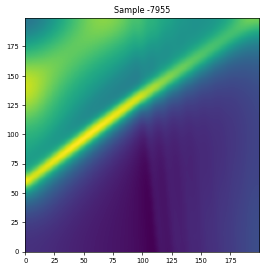

In [4]:
## Plot Noddy model with specific ID ##

with open("ltegeo/configs/train_swinir-lte_geo_synthetic.yaml", "r") as f:
    cfg = yaml.load(f, Loader=yaml.FullLoader)

args = cfg["train_dataset"]["dataset"]["args"]
args = {
    "root_path": "C:/Users/Public/scratch/Noddy_1M",
    "load_magnetics": True,
    "noddylist": "C:/Users/Public/scratch/Noddy_1M/models.csv",
    "blocklist": "C:/Users/Public/scratch/Noddy_10k/models_10k.csv",
    "hr_line_spacing": 4,
    "norm": [-10000, 10000],
}

dset = HRLRNoddyverse(
    root_path=args["root_path"],
    norm=args["norm"],
    noddylist=args["noddylist"],
    blocklist=args["blocklist"],
    hr_line_spacing=args["hr_line_spacing"],
    load_magnetics=args["load_magnetics"],
)
dset.scale = 4
unorm = Norm(args["norm"][0], args["norm"][1]).inverse_mmc

noddydir = "C:/Users/Public/scratch/Noddy_1M/PLUG_PLUG_FOLD/models_by_code/models/PLUG_PLUG_FOLD/20-09-10-14-45-47-034629522"
noddystr = "20-09-10-14-45-47-034629522"

for sample_id in (
    -7955,
    -7904,
    -7844,
    -7826,
    -7779,
    -7700
):
    plt.figure(dpi=60)
    plt.title(f"Sample {sample_id}")
    plt.imshow(dset[sample_id]["gt_grid"].squeeze())
    plt.show()
    break

In [5]:
## Plot all GT and low resolution grids ##
with open(
    "D:/luke/phd/ch2/ltegeo/configs/train_swinir-lte_geo_synthetic.yaml", "r"
) as f:
    cfg = yaml.load(f, Loader=yaml.FullLoader)

sample_id = -7779
max_scale = 6
scale_range = (2, 4, 6)  # range(1, max_scale + 1, 2)

args = cfg["train_dataset"]["dataset"]["args"]
dset = HRLRNoddyverse(
    root_path=args["root_path"],
    norm=args["norm"],
    noddylist=args["noddylist"],
    blocklist=args["blocklist"],
    hr_line_spacing=args["hr_line_spacing"],
    load_magnetics=args["load_magnetics"],
)
dset.scale = 1
unorm = Norm(args["norm"][0], args["norm"][1]).inverse_mmc

grids = {}
for scale in scale_range:
    dset.scale = scale
    grids[f"{scale}x"] = (dset[sample_id]["gt_grid"], dset[sample_id]["lr_grid"])

fig, axes = plt.subplots(len(scale_range), 2, dpi=100, figsize=(6, 12), layout="constrained")
plt.suptitle(f"Sample {sample_id}")
for [axgt, axlr], grid in zip(axes, grids):
    gt_ls = int(grid[:-1]) * 20 * args["hr_line_spacing"]
    axgt.set_title(f"{grid} GT\n {gt_ls} m Line Spacing")
    cclr = plot_gt(axgt, grids[grid][0].squeeze(), args, scale=int(grid[:-1]))

    axlr.set_title(f"{grid} Gridded LR\n")
    cbar = axlr.imshow(
        unorm(grids[grid][1]).squeeze(),
        interpolation=None,
        origin="lower",
        cmap=cc.cm.CET_L1,
    )
    axlr.set_xticks([])
    axlr.set_yticks([])
    
fig.colorbar(mappable=cclr, ax=axes, orientation="horizontal", label="Sampled TMI (nT)")
fig.colorbar(mappable=cbar, ax=axes, orientation="horizontal", label="Grid TMI (nT)")

plt.savefig(
    f"D:/luke/phd/figures/ch2/lr_samples_{sample_id}{ext}",
    facecolor="white",
    transparent=False,
)
plt.close()
print(f"D:/luke/phd/figures/ch2/lr_samples_{sample_id}{ext}")
# plt.show()

D:/luke/phd/figures/ch2/lr_samples_-7779.svg


In [6]:
int(grid[:-1])  * 20 * args["hr_line_spacing"]

480

tensor(0.4661)


d:\luke\Miniconda3\envs\bridging\Lib\site-packages\torch\functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\TensorShape.cpp:3484.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


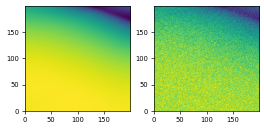

In [7]:
### TEST IQA ###
norm = Norm(-10000, 10000, out_vals=(0, 1)).min_max_clip
unnorm = Norm(-10000, 10000, out_vals=(0, 1)).inverse_mmc

t1 = parse_geophysics(
    Path(
        "D:/luke/data_source/Noddy_data/Noddy_1M/DYKE_DYKE_DYKE/models_by_code/models/DYKE_DYKE_DYKE/20-09-04-15-13-14-866983543.his"
    ),
    mag=True,
)
t1 = torch.from_numpy(next(t1)).unsqueeze(0).unsqueeze(0)
t1 = norm(t1)

t1.clamp_(0, 1)
# print(t1)

t2 = parse_geophysics(
    Path(
        "D:/luke/data_source/Noddy_data/Noddy_1M/DYKE_DYKE_DYKE/models_by_code/models/DYKE_DYKE_DYKE/20-09-04-15-13-14-866983543.his"
    ),
    mag=True,
)
t2 = torch.from_numpy(next(t2)).unsqueeze(0).unsqueeze(0)
t2 = norm(t2) - torch.rand_like(t2) * 0.1
t2.clamp_(0, 1)
# print(t2)

print(piq.FSIMLoss(chromatic=False)(t1, t2))

plt.figure(dpi=60)
plt.subplot(1,2,1)
plt.imshow(t1.numpy().squeeze())
plt.subplot(1,2,2)
plt.imshow(t2.numpy().squeeze())

In [8]:
### Plot performance of all models on Noddy Synthetic ###

with open("ltegeo/configs/inference.yaml", "r") as f:
    cfg = yaml.load(f, Loader=yaml.FullLoader)

names = cfg["range_model_names"]
scales = cfg["range_model_scales"]
inference_output_dir = cfg["inference_output_dir"]

# Define Data ###
spec = cfg["test_dataset"]
dataset = datasets.make(spec["dataset"])
dataset = datasets.make(spec["wrapper"], args={"dataset": dataset})

if cfg["limit_to_plots"]:
    samples = cfg["plot_samples"][1]
    samples.extend(cfg["plot_samples"][0])
    dataset = Subset(dataset, samples)

loader = DataLoader(
    dataset,
    batch_size=spec["batch_size"],
    num_workers=cfg.get("num_workers"),
    persistent_workers=bool(cfg.get("num_workers")),
    pin_memory=True,
)
[n for n in zip(names, scales)]

Using cached file d:\luke\phd\ch2\.noddy_allowlist.npy


[('silky_pie', 2),
 ('annoyed_degree', 3),
 ('eligible_toast', 4),
 ('olympic_mackerel', 5),
 ('major_fish', 6),
 ('disappointed_neutron', 9)]

In [9]:
# for model_name, scale in tqdm(zip(names, scales), total=len(names)):
i = 0
if 1:
    model_name, scale = names[i], scales[i]
    print(f"Performing {scale}x inference using {model_name}")
    ### Pack Options
    model_dir = Path(cfg["model_dir"])
    model_paths = list(model_dir.glob(f"**/*{model_name}*last.pth"))
    if len(model_paths) != 1:
        raise FileNotFoundError()
    model_spec = torch.load(model_paths[0], map_location="cuda")["model"]
    model = models.make(model_spec, load_sd=True).to("cuda")
    opts = dict(
        model_name=model_name,
        model_path=model_paths[0],
        save_path=Path(cfg["inference_output_dir"] or f"ltegeo/inference/{model_name}"),
        rgb_range=cfg["rgb_range"],
        shave_factor=0,  # pixels to shave (edges may include NaN)
        ids=cfg["plot_samples"],  # Sample IDs
        mag=cfg["test_dataset"]["dataset"]["args"]["load_magnetics"],
        grv=cfg["test_dataset"]["dataset"]["args"]["load_gravity"],
        eval_bsize=cfg["eval_bsize"],
        limit_to_plots=cfg["limit_to_plots"],
        gt_list=cfg["test_dataset"]["dataset"]["args"]["root_path"],
    )

    scale_min = spec["wrapper"]["args"]["scale_min"]
    scale_max = spec["wrapper"]["args"]["scale_max"]

    print(
        f"\nModel: {opts['model_path'].absolute()}\n"
        f"Saving to: {opts['save_path'].absolute()}"
    )

Performing 2x inference using silky_pie

Model: D:\luke\phd\ch2\ltegeo\save\_train_swinir-lte_geo\230505-1731_silky_pie_1417\silky_pie_1417_epoch-last.pth
Saving to: D:\luke\phd\ch2\ltegeo\inference\range_test


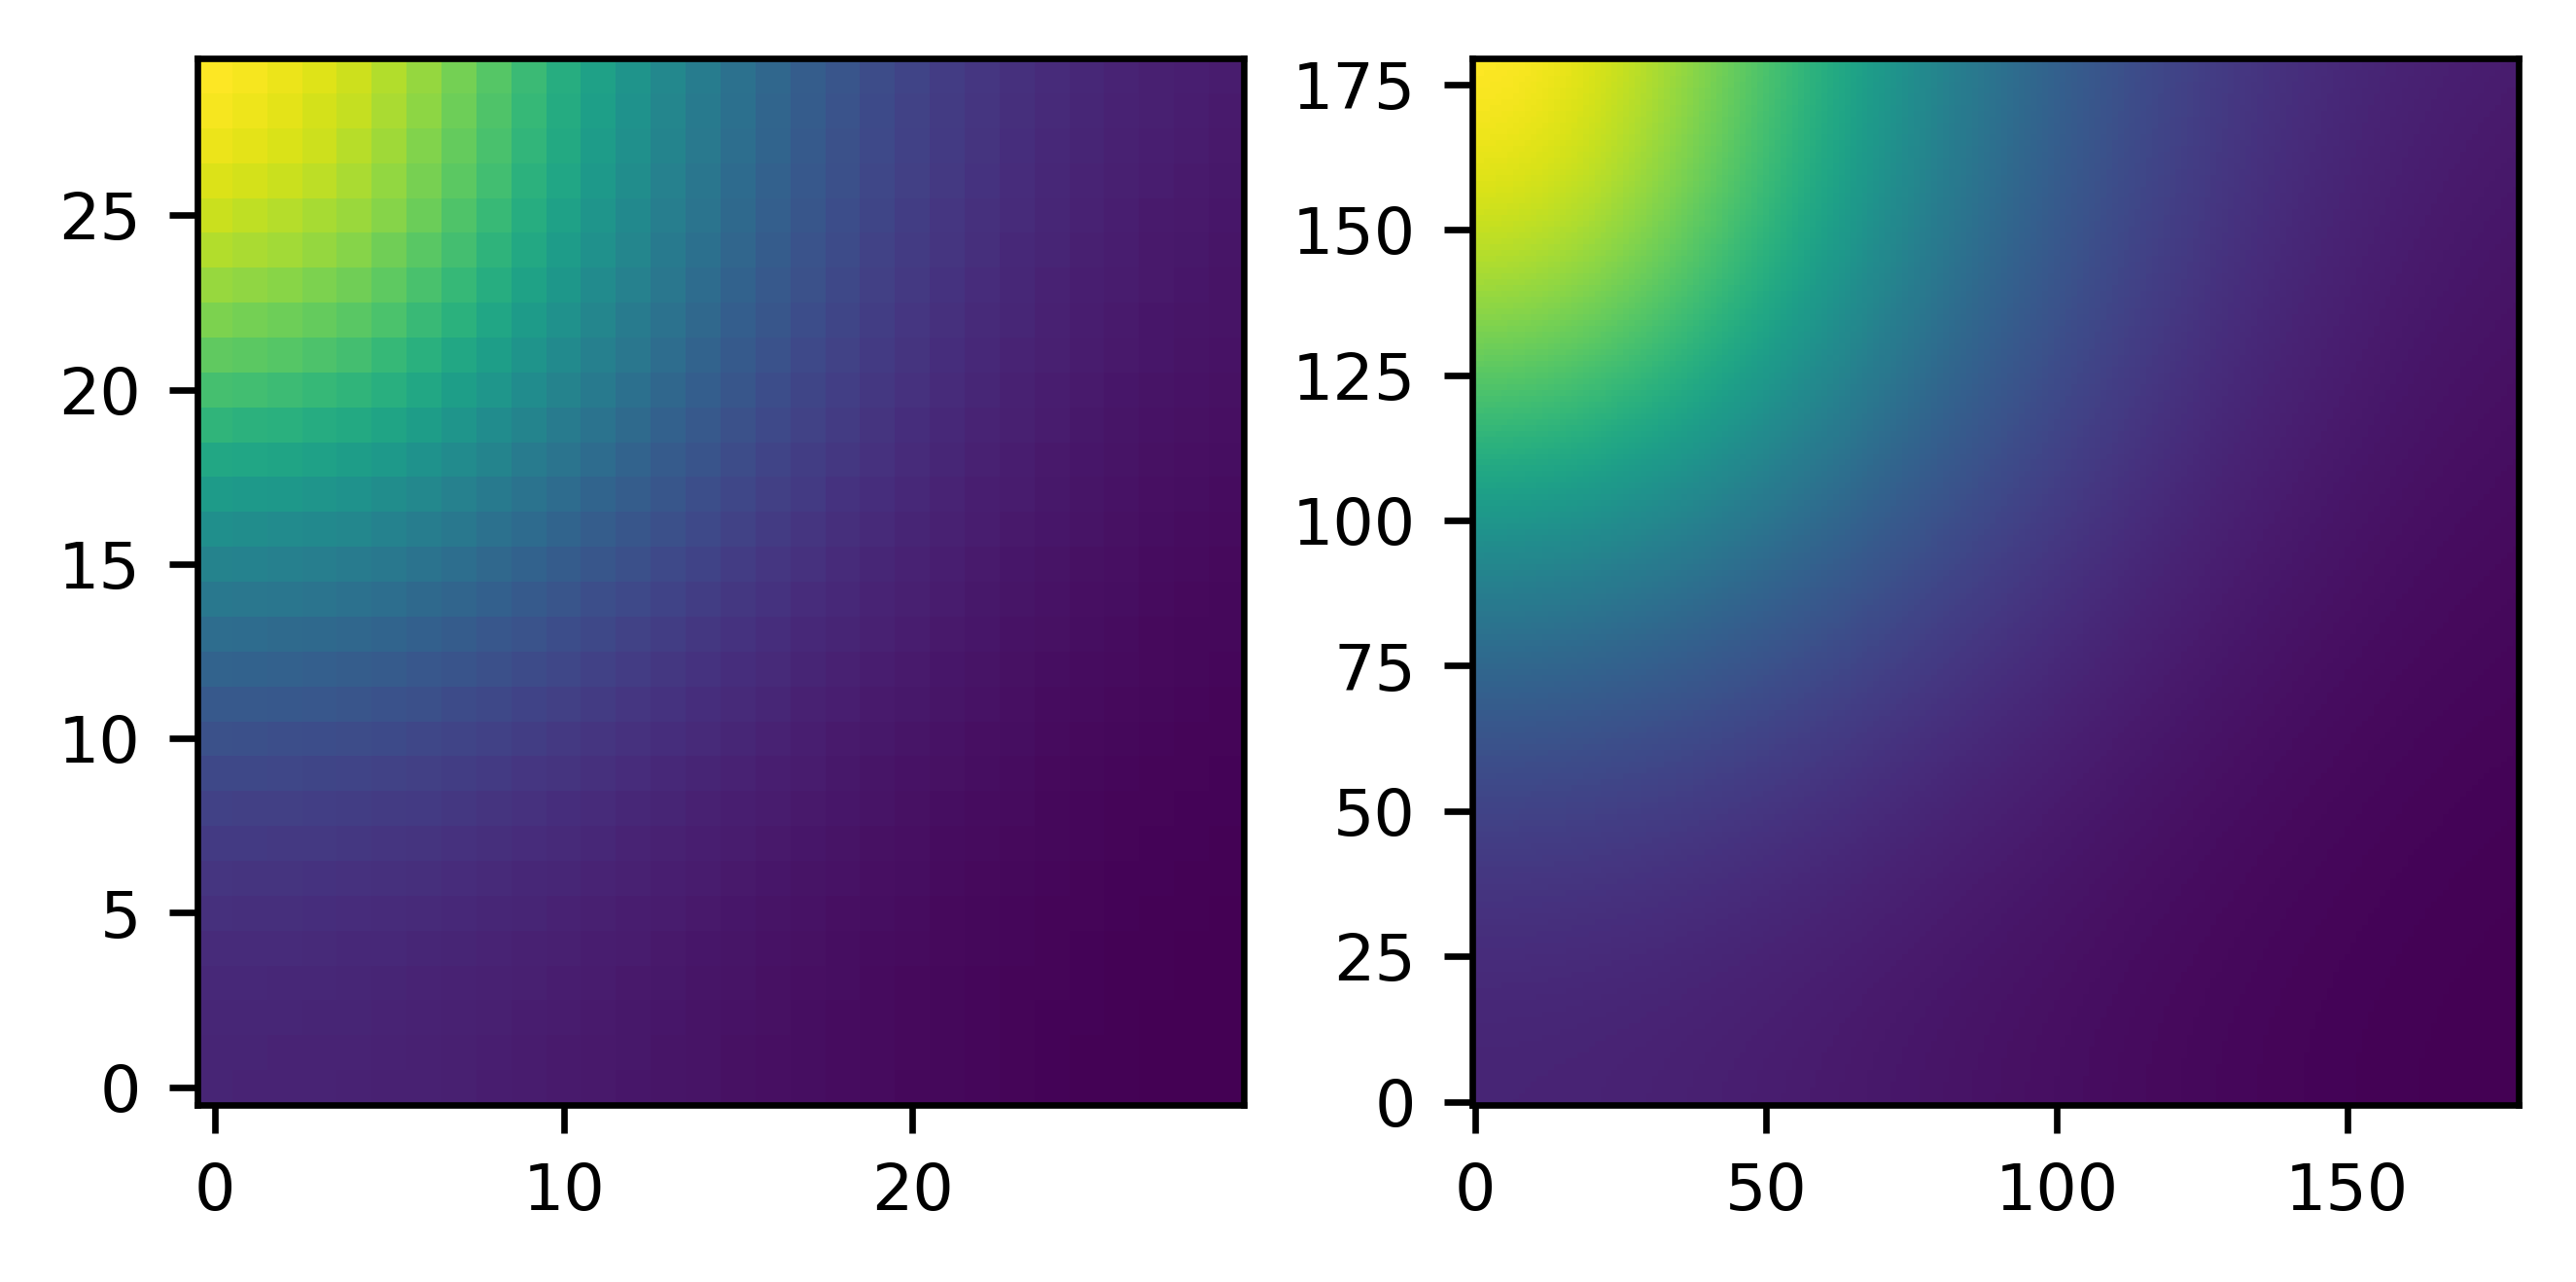

In [10]:
### Plot real data via HRLR dataset ###
index = 10

with open("D:/luke/phd/ch2/ltegeo/configs/train_swinir-lte_geo_synthetic.yaml", "r") as f:
    config = yaml.load(f, Loader=yaml.FullLoader)

spec = config.get("train_dataset")

dataset = datasets.make(spec["dataset"])
dataset = datasets.make(spec["wrapper"], args={"dataset": dataset})

dataset.dataset.scale = 6

lr = dataset.dataset[index]["lr_grid"]
gt = dataset.dataset[index]["hr_grid"]

plt.figure()
plt.subplot(1,2,1)
plt.imshow(lr.squeeze())
plt.subplot(1,2,2)
plt.imshow(gt.squeeze())

In [11]:
## Do Inference ###
# results_dict = {}
# custom_results_dict = {}

# scale_min = 4
# scale_max = 4

# pbar_m = tqdm(range(scale_min, scale_max + 1))
# for scale in pbar_m:
#     pbar_m.set_description(f"{scale}x scale")
#     opts["shave"] = scale * opts["shave_factor"]

#     # lazy way to reset custom grid opts
#     opts["ids"] = cfg["plot_samples"]
#     opts["gt"] = None
#     opts["set"] = "test"

#     dataset.scale = scale
#     dataset.scale_min = scale
#     dataset.scale_max = scale
#     if cfg["limit_to_plots"]:
#         # Not sure how to better handle Subset dataset
#         dataset.dataset.scale = scale
#         dataset.dataset.scale_min = scale
#         dataset.dataset.scale_max = scale

#     results = eval(model, scale, loader, opts, cfg=cfg)
#     results_dict[f"{scale}x"] = results
#     pbar_m.write(f"{scale}x scale - Mean:")
#     pbar_m.write(
#         ", ".join(
#             f"{metric_name}: {metric_value:.4f}"
#             for metric_name, metric_value in results.items()
#         )
#     )

In [12]:
# plt_results(results_dict, opts)

In [13]:
model.eval()
for i, batch in enumerate(loader):
    inp = batch["inp"].to("cuda", non_blocking=True)
    coord = batch["coord"].to("cuda", non_blocking=True)
    cell = batch["cell"].to("cuda", non_blocking=True)
    # batch["gt"] = batch["gt"].to("cuda", non_blocking=True)

    with torch.no_grad():
        if opts["eval_bsize"]:
            pred = batched_predict(model, inp, coord, cell, opts["eval_bsize"])
        else:
            pred = model(inp, coord, cell)

    pred, batch = reshape(batch, h_pad=0, w_pad=0, coord=coord, pred=pred)
    lr = batch["inp"].detach().cpu().squeeze().numpy()
    hr = batch["gt"].detach().cpu().squeeze().numpy()
    sr = pred.detach().cpu().squeeze().numpy()
    break

NameError: name 'canny' is not defined

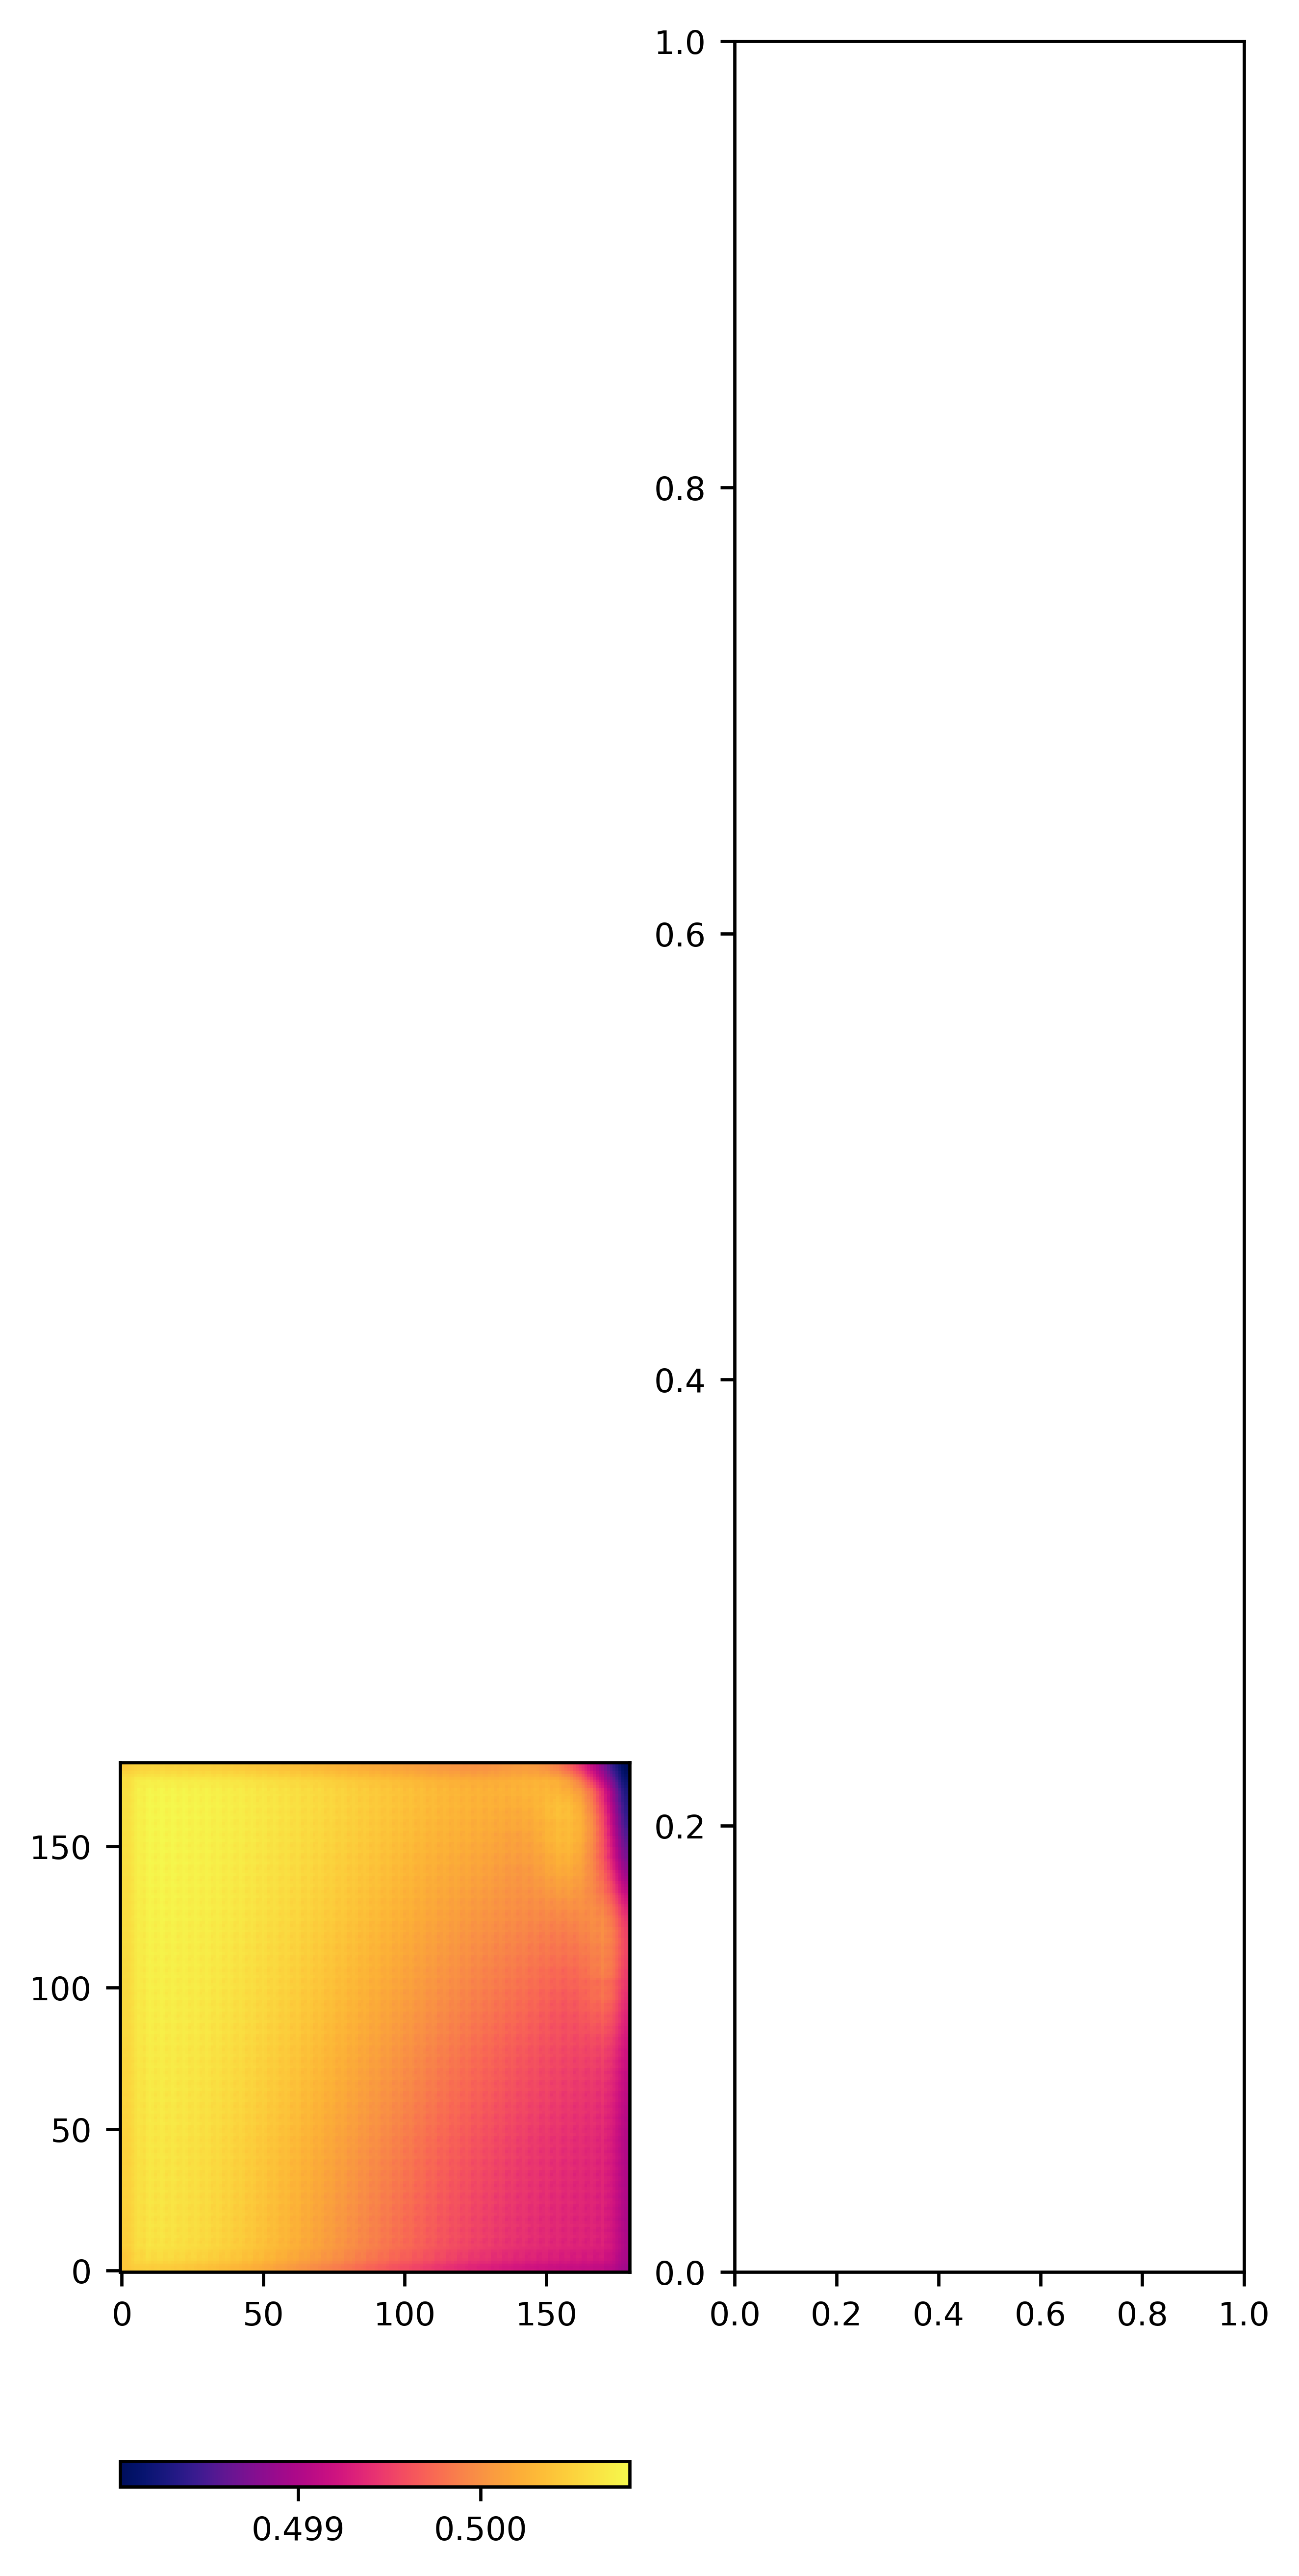

In [14]:
# import cv2
from ltegeo.inference import plot_canny

fig, [ax0, ax1] = plt.subplots(1, 2)

c0 = ax0.imshow(sr, cmap=cc.cm.CET_L8, origin="lower", interpolation="nearest")
plt.colorbar(c0, orientation="horizontal", ax=ax0)
plot_canny(
    ax1,
    hr,
    sr,
    np.array(Image.fromarray(lr).resize(hr.shape, Image.Resampling.BICUBIC)),
    sigma=1,
)

In [ ]:
mask = np.zeros_like(hr)
mask[:, ::4] = 1

# cmap.set_bad(alpha=0)
fig, ax = plt.subplots(1, 1, constrained_layout=True, figsize=(10, 10), dpi=600)
cgry = ax.imshow(unorm(hr), cmap=cc.cm.CET_L1, interpolation="nearest", origin="lower")
cclr = ax.imshow(
    unorm(hr), cmap=cc.cm.CET_L8, interpolation="nearest", origin="lower", alpha=mask
)
plt.colorbar(mappable=cgry, ax=ax, orientation="horizontal", label="Unsampled")
plt.colorbar(mappable=cclr, ax=ax, orientation="horizontal", label="Line Sampled")